# Minimierung der Tardiness jedes Produktionsauftrags

In [1]:
# Datenzugriff
from configs.path_manager import get_path

# Utils
from src.utils.new_filter import *
import src.utils.presenter as show
from src.utils.analize import check_constrains as check

# Solver Model
from src.models.cp import tardiness_scheduling as cp_tard_schedule
from src.models.cp import tardiness_rescheduling as cp_tard_reschedule

# Simulation
from src.simulation.ProductionRollingSimulation import ProductionSimulation

# Extern
import pandas as pd

pd.set_option('display.min_rows', 12)
pd.set_option('display.max_rows', 16)

In [2]:
# Harte Abbruchbedingung für die Scheduler
max_time = 60*15     # 15 min

# Simulation
simulation = ProductionSimulation(sigma = 0.15)

## I. Laden des fertigen Job-Shop Scheduling Problems und der dazugehörigen Produktionsauftragsinformationen

In [3]:
basic_data_path = get_path("data", "basic")
df_jssp = pd.read_csv(basic_data_path / "jssp_final.csv")
df_jssp

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,0,M00,76
1,J25-0000,8,1,M01,69
2,J25-0000,8,2,M03,76
3,J25-0000,8,3,M05,51
4,J25-0000,8,4,M02,85
5,J25-0000,8,5,M09,11
...,...,...,...,...,...
72494,J25-7249,4,4,M03,26
72495,J25-7249,4,5,M04,69
72496,J25-7249,4,6,M08,21


In [4]:
df_jobs_times = pd.read_csv(basic_data_path / "jobs_times_final.csv")
df_jobs_times

,Job,Routing_ID,Arrival,Ready Time,End,Processing Time,Deadline
0,J25-0000,8,79,1440,2704.0,597,3660
1,J25-0001,6,129,1440,2336.0,416,2338
2,J25-0002,0,198,1440,2925.0,395,3744
3,J25-0003,2,243,1440,2801.0,568,3379
4,J25-0004,3,287,1440,2697.0,655,4856
5,J25-0005,1,498,1440,2630.0,510,3106
...,...,...,...,...,...,...,...
7244,J25-7244,3,518085,518400,520251.0,655,520389
7245,J25-7245,9,518089,518400,520296.0,540,519640
7246,J25-7246,6,518116,518400,520027.0,416,520157


## Tag 1
- Am Tag 0 kommen die ersten Produktionsaufträge an, somit kann noch nichts geplant werden
- Am Tag 1 findet die initiale Planung statt

In [5]:
day_length = 1440

day_numb = 1
day_start = day_length*day_numb
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 01: [1440, 2880)


In [6]:
# "neue" und unerledigte Jobs
df_jobs_times_current = get_current_jobs(
    df_jobs_times, df_previous_not_started = None, ready_time=day_start
)
df_jobs_times_current

,Job,Routing_ID,Arrival,Ready Time,End,Processing Time,Deadline
0,J25-0000,8,79,1440,2704.0,597,3660
1,J25-0001,6,129,1440,2336.0,416,2338
2,J25-0002,0,198,1440,2925.0,395,3744
3,J25-0003,2,243,1440,2801.0,568,3379
4,J25-0004,3,287,1440,2697.0,655,4856
5,J25-0005,1,498,1440,2630.0,510,3106
6,J25-0006,9,790,1440,2905.0,540,3539
7,J25-0007,5,925,1440,2930.0,496,2929
8,J25-0008,4,988,1440,2986.0,393,3541
9,J25-0009,7,1004,1440,3045.0,539,3578


In [7]:
df_jssp_current = filter_current_jssp(df_jssp, df_jobs_times_current)
df_jssp_current

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,0,M00,76
1,J25-0000,8,1,M01,69
2,J25-0000,8,2,M03,76
3,J25-0000,8,3,M05,51
4,J25-0000,8,4,M02,85
5,J25-0000,8,5,M09,11
...,...,...,...,...,...
154,J25-0015,5,4,M08,48
155,J25-0015,5,5,M09,72
156,J25-0015,5,6,M00,47


### Scheduling

#### a) Summe der Tardiness minimieren

$$
\min \; \sum_{j \in J} \max(0,\; C_j - d_j)
$$


- $J$: Menge aller Jobs
- $C_j$: tatsächliche Fertigstellungszeit (Completion Time) von Job $j$
- $d_j$: Deadline von Job $j$
- $\max(0,\; C_j - d_j)$: Tardiness von Job $j$
- Die Summe betrachtet **nur verspätete Jobs** – Frühfertigungen zählen nicht.

**Erklärung:**
Diese Zielfunktion minimiert die **Gesamtheit aller Verspätungen**, d. h. die Summe aller positiven Abweichungen von den Deadlines.

In [8]:
# Scheduling
df_schedule = cp_tard_schedule.solve_jssp_sum(
    df_jssp_current, df_jobs_times_current, earliest_start_column = "Ready Time",
    msg=False, timeLimit=max_time, gapRel= 0.01
)
df_schedule


Solver-Status         : OPTIMAL
Summe Tardiness        : 0.0
Best Objective Bound   : 0.0
Laufzeit               : 0.04 Sekunden


,Job,Routing_ID,Arrival,Ready Time,Deadline,Operation,Machine,Start,Processing Time,End
0,J25-0005,1,498,1440,3106,0,M00,1440,43,1483
1,J25-0007,5,925,1440,2929,0,M02,1440,84,1524
2,J25-0013,3,1192,1440,2567,0,M01,1440,81,1521
3,J25-0011,1,1030,1440,3210,0,M00,1483,43,1526
4,J25-0001,6,129,1440,2338,0,M01,1521,46,1567
5,J25-0013,3,1192,1440,2567,1,M02,1524,95,1619
...,...,...,...,...,...,...,...,...,...,...
154,J25-0000,8,79,1440,3660,9,M08,2844,74,2918
155,J25-0012,2,1103,1440,4385,9,M04,2862,33,2895
156,J25-0004,3,287,1440,4856,6,M07,2863,85,2948


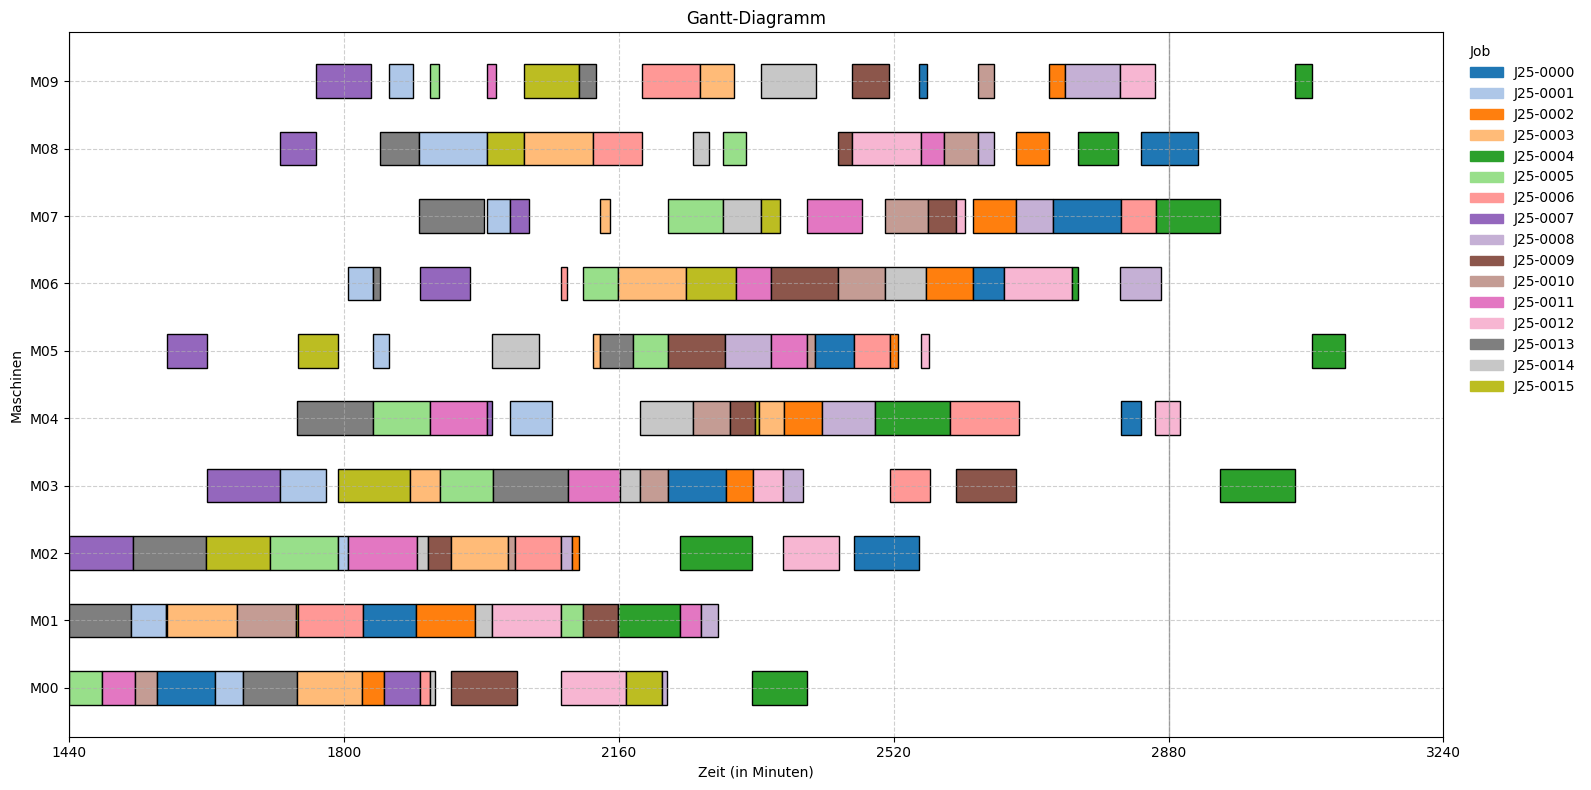

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [9]:
show.plot_gantt(df_schedule, perspective="Machine")
check.is_machine_conflict_free(df_schedule)
check.is_operation_sequence_correct(df_schedule)
check.is_job_timing_correct(df_schedule)
check.is_start_correct(df_schedule)

### Simulation

In [10]:
simulation.run(dframe_schedule_plan= df_schedule, start_time = day_start, end_time=day_end)

[Day 1 00:00:00] Job J25-0005 started on M00
[Day 1 00:00:00] Job J25-0007 started on M02
[Day 1 00:00:00] Job J25-0013 started on M01
[Day 1 00:40:00] Job J25-0005 finished on M00 (after 40 minutes)
[Day 1 00:43:00] Job J25-0011 started on M00
[Day 1 01:19:00] Job J25-0013 finished on M01 (after 79 minutes)
[Day 1 01:19:00] Job J25-0011 finished on M00 (after 36 minutes)
[Day 1 01:21:00] Job J25-0001 started on M01
[Day 1 01:25:00] Job J25-0007 finished on M02 (after 85 minutes)
[Day 1 01:25:00] Job J25-0013 started on M02
[Day 1 01:26:00] Job J25-0010 started on M00
[Day 1 01:52:00] Job J25-0010 finished on M00 (after 26 minutes)
[Day 1 01:55:00] Job J25-0000 started on M00
[Day 1 02:10:00] Job J25-0001 finished on M01 (after 49 minutes)
[Day 1 02:10:00] Job J25-0007 started on M01
[Day 1 02:12:00] Job J25-0007 finished on M01 (after 02 minutes)
[Day 1 02:12:00] Job J25-0003 started on M01
[Day 1 02:12:00] Job J25-0007 started on M05
[Day 1 02:59:00] Job J25-0007 finished on M05 (aft

In [11]:
df_execution = simulation.get_finished_operations_df()
df_execution

,Routing_ID,Job,Operation,Machine,Arrival,Start,Processing Time,End
0,8,J25-0000,0,M00,79,1555.0,70.0,1625.0
1,8,J25-0000,1,M01,79,1848.0,65.0,1913.0
2,8,J25-0000,2,M03,79,2267.0,72.0,2339.0
3,8,J25-0000,3,M05,79,2507.0,55.0,2562.0
4,8,J25-0000,4,M02,79,2562.0,98.0,2660.0
5,8,J25-0000,5,M09,79,2674.0,11.0,2685.0
...,...,...,...,...,...,...,...,...
142,5,J25-0015,4,M08,1436,1988.0,54.0,2042.0
143,5,J25-0015,5,M09,1436,2042.0,82.0,2124.0
144,5,J25-0015,6,M00,1436,2188.0,53.0,2241.0


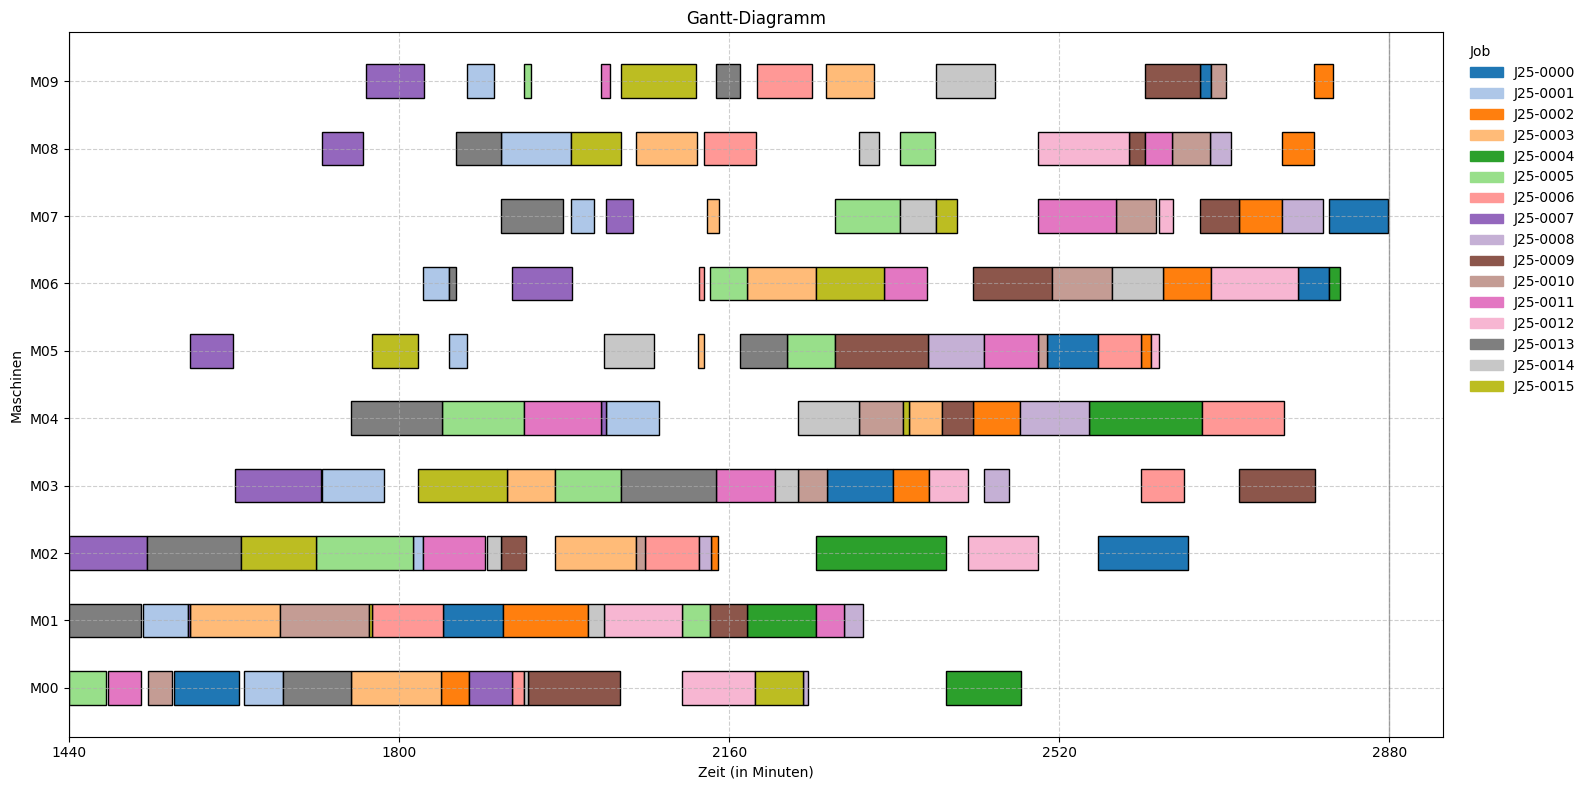

In [12]:
show.plot_gantt(df_execution, perspective="Machine")

In [13]:
df_active = simulation.get_active_operations_df()
df_active

,Job,Operation,Machine,Arrival,Start,Planned Duration,Processing Time,Expected End,End
0,J25-0000,8,M04,79,2879.0,26,24.0,2905.0,2903.0
1,J25-0004,5,M08,287,2826.0,52,55.0,2878.0,2881.0
2,J25-0006,9,M07,790,2879.0,45,44.0,2924.0,2923.0
3,J25-0008,8,M09,988,2818.0,72,67.0,2890.0,2885.0


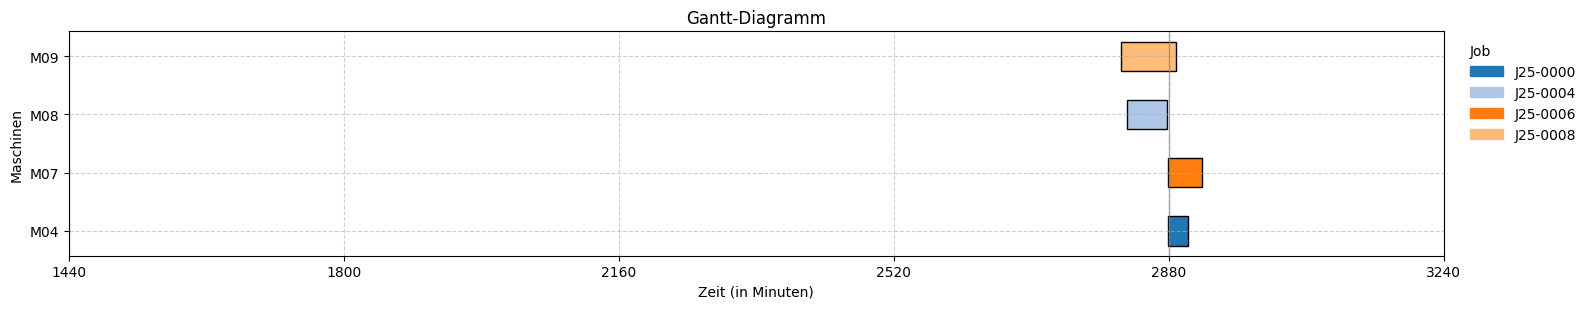

In [14]:
show.plot_gantt(df_active, perspective="Machine", duration_column="Planned Duration")

In [15]:
df_not_started = simulation.get_not_started_operations_df(df_schedule)
df_not_started

,Job,Routing_ID,Arrival,Ready Time,Deadline,Operation,Machine,Start,Processing Time,End
0,J25-0000,8,79,1440,3660,9,M08,2844,74,2918
1,J25-0004,3,287,1440,4856,6,M07,2863,85,2948
2,J25-0004,3,287,1440,4856,7,M03,2948,98,3046
3,J25-0004,3,287,1440,4856,8,M09,3046,22,3068
4,J25-0004,3,287,1440,4856,9,M05,3068,43,3111
5,J25-0008,4,988,1440,3541,9,M06,2817,53,2870
6,J25-0012,2,1103,1440,4385,8,M09,2817,45,2862
7,J25-0012,2,1103,1440,4385,9,M04,2862,33,2895


#### b) größte Tardiness minimieren

$$
\min \; \max_{j \in J} \left( \max(0,\; C_j - d_j) \right)
$$


- $J$: Menge aller Jobs
- $C_j$: tatsächliche Fertigstellungszeit (Completion Time) von Job $j$
- $d_j$: Deadline von Job $j$
- $\max(0,\; C_j - d_j)$: Tardiness des Jobs $j$
- Die äußere $\max$-Funktion bestimmt den Job mit der **größten Verspätung**

**Erklärung:**
Diese Zielfunktion minimiert die **schlimmste Deadline-Überschreitung** unter allen Jobs. Frühfertigungen fließen dabei **nicht** ein.

In [16]:
# Scheduling
df_schedule_b = cp_tard_schedule.solve_jssp_max(
    df_jssp_current, df_jobs_times_current, earliest_start_column = "Ready Time",
    msg=False, timeLimit=max_time, gapRel= 0.01
)
df_schedule_b


Solver-Status        : OPTIMAL
Maximale Tardiness     : 0.0
Best Objective Bound   : 0.0
Laufzeit               : 0.03 Sekunden


,Job,Routing_ID,Arrival,Ready Time,Deadline,Operation,Machine,Start,Processing Time,End
0,J25-0005,1,498,1440,3106,0,M00,1440,43,1483
1,J25-0007,5,925,1440,2929,0,M02,1440,84,1524
2,J25-0013,3,1192,1440,2567,0,M01,1440,81,1521
3,J25-0011,1,1030,1440,3210,0,M00,1483,43,1526
4,J25-0001,6,129,1440,2338,0,M01,1521,46,1567
5,J25-0013,3,1192,1440,2567,1,M02,1524,95,1619
...,...,...,...,...,...,...,...,...,...,...
154,J25-0000,8,79,1440,3660,9,M08,2844,74,2918
155,J25-0012,2,1103,1440,4385,9,M04,2862,33,2895
156,J25-0004,3,287,1440,4856,6,M07,2863,85,2948


## Tag 2
- hier findet die Neuplanung statt, also das Scheduling mit bestimmter Berücksichtigung der Simulation

In [17]:
day_numb = 2
day_start = day_length*day_numb
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 02: [2880, 4320)


In [18]:
# "neue" und unerledigte Jobs
df_jobs_times_current = get_current_jobs(df_jobs_times, df_not_started, ready_time=day_start)
df_jobs_times_current

,Job,Routing_ID,Arrival,Ready Time,End,Processing Time,Deadline
0,J25-0000,8,79,1440,2704.0,597,3660
4,J25-0004,3,287,1440,2697.0,655,4856
8,J25-0008,4,988,1440,2986.0,393,3541
12,J25-0012,2,1103,1440,3011.0,568,4385
16,J25-0016,6,1500,2880,3858.0,416,4558
17,J25-0017,7,1864,2880,4621.0,539,4980
...,...,...,...,...,...,...,...
32,J25-0032,6,2654,2880,4856.0,416,3881
33,J25-0033,2,2660,2880,5305.0,568,6738
34,J25-0034,8,2715,2880,5271.0,597,6387


In [19]:
df_jssp_current = filter_current_jssp(
    df_jssp = df_jssp,
    df_jobs_times_current = df_jobs_times_current,
    exclusion_dataframes_list = [df_active, df_execution]
)
df_jssp_current

,Job,Routing_ID,Operation,Machine,Processing Time
9,J25-0000,8,9,M08,74
46,J25-0004,3,6,M07,85
47,J25-0004,3,7,M03,98
48,J25-0004,3,8,M09,22
49,J25-0004,3,9,M05,43
89,J25-0008,4,9,M06,53
...,...,...,...,...,...
374,J25-0037,7,4,M04,32
375,J25-0037,7,5,M06,88
376,J25-0037,7,6,M08,19


### a) einfache Neuplanung
- berücksichtigt lediglich die aktiven Arbeitsgänge (Operationen)

In [20]:
df_schedule_simple = cp_tard_reschedule.solve_jssp_sum_with_fixed_ops(
    df_jssp_current, df_jobs_times_current, df_active,
    reschedule_start = day_start, msg=False, timeLimit=max_time, gapRel= 0.02
)
df_schedule_simple


Solver-Status         : OPTIMAL
Summe Tardiness       : 0.0
Best Objective Bound  : 0.0
Laufzeit              : 0.04 Sekunden


,Job,Routing_ID,Arrival,Ready Time,Deadline,Operation,Machine,Start,Processing Time,End
0,J25-0031,1,2567,2880,4377,0,M00,2880,43,2923
1,J25-0032,6,2654,2880,3881,0,M01,2880,46,2926
2,J25-0035,5,2726,2880,4126,0,M02,2880,84,2964
3,J25-0008,4,988,1440,3541,9,M06,2885,53,2938
4,J25-0012,2,1103,1440,4385,8,M09,2885,45,2930
5,J25-0000,8,79,1440,3660,9,M08,2903,74,2977
...,...,...,...,...,...,...,...,...,...,...
222,J25-0034,8,2715,2880,6387,7,M07,4737,89,4826
223,J25-0030,0,2313,2880,6015,9,M09,4745,21,4766
224,J25-0033,2,2660,2880,6738,8,M09,4774,45,4819


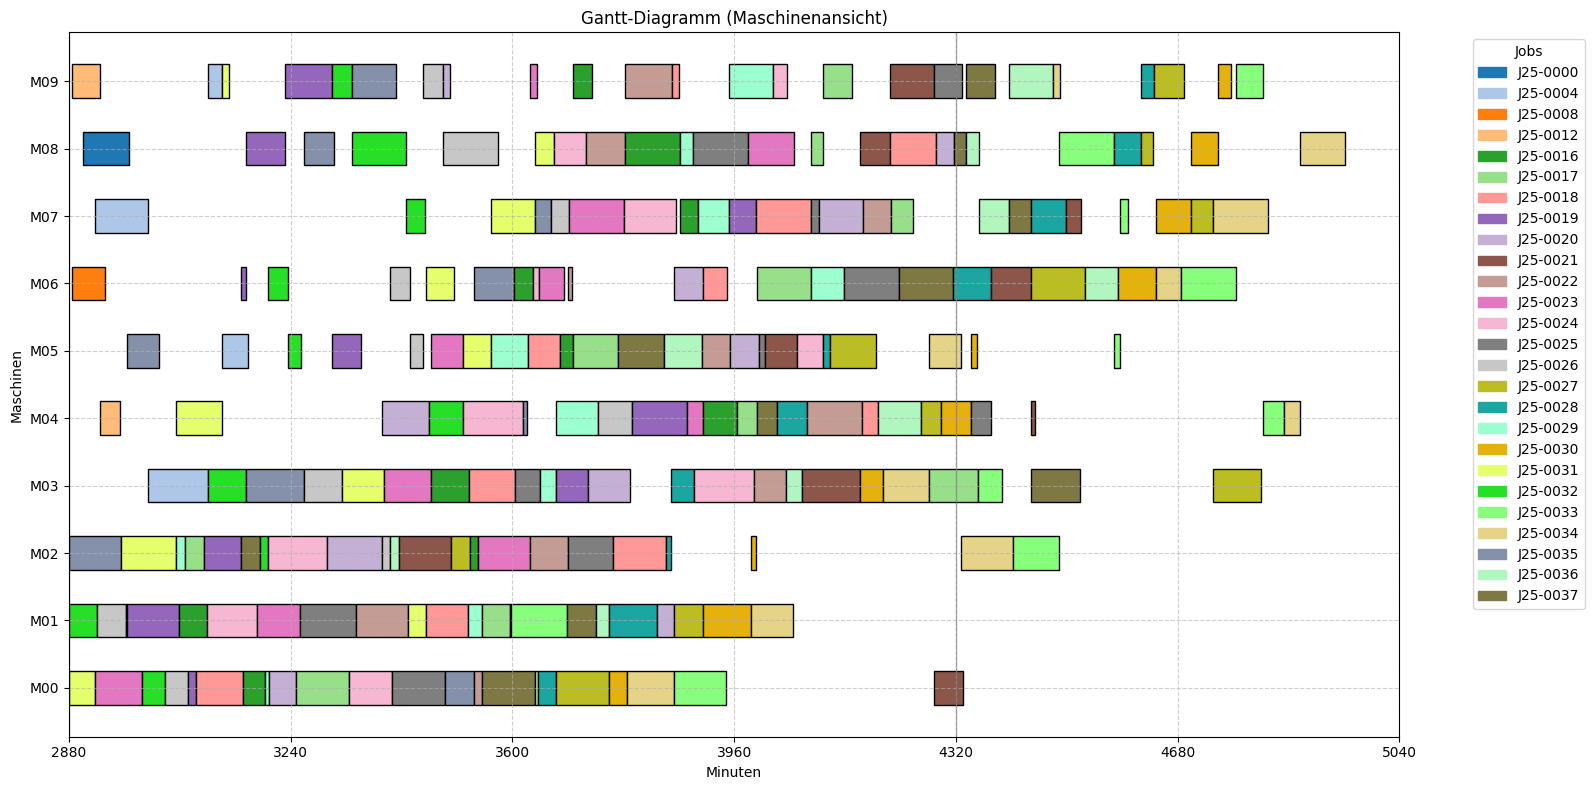

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [21]:
df_temp =  df_schedule_simple

show.plot_gantt_machines(df_temp)
check.is_machine_conflict_free(df_temp)
check.is_operation_sequence_correct(df_temp)
check.is_job_timing_correct(df_temp)
check.is_start_correct(df_temp)

#### Check der Bedingungen des kombinierten Datensatzes aus den Simulationsdaten mit dem neuen Schedule

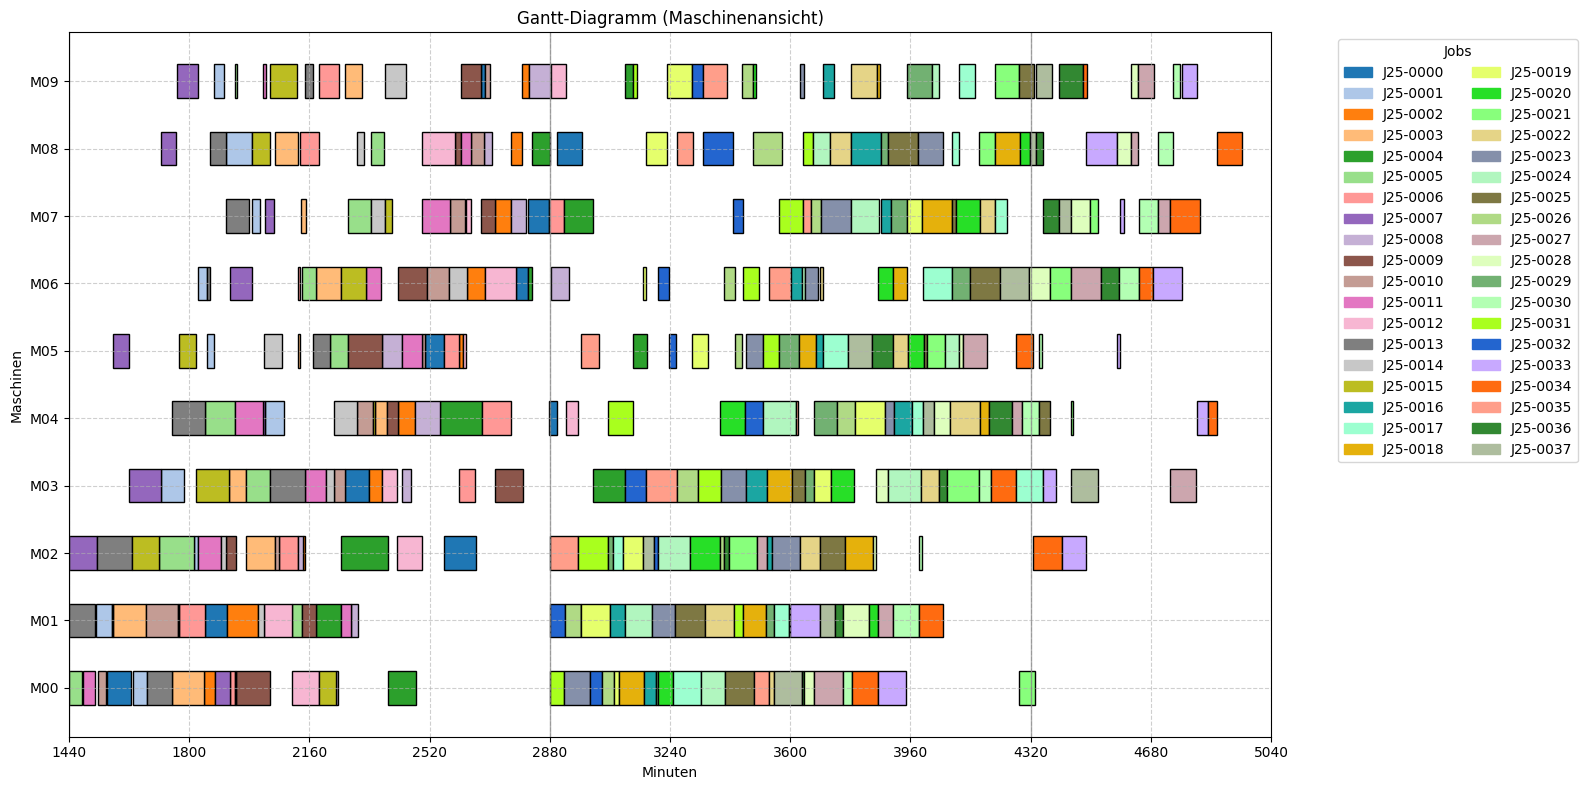

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [22]:
df_reschedule = df_schedule_simple

columns = ["Job", "Operation", "Machine", "Arrival", "Start", "Processing Time", "End"]
df_combined = pd.concat([df_execution, df_active[columns], df_reschedule[columns]], ignore_index=True)
show.plot_gantt_machines(df_combined)
check.is_machine_conflict_free(df_combined)
check.is_operation_sequence_correct(df_combined)
check.is_job_timing_correct(df_combined)
check.is_start_correct(df_combined)


### b) Neuplanung mit zusätzlich Minimierung der Planabweichung für die zuvor geplante Arbeitsgänge

In [23]:
df_schedule_devpen = cp_tard_reschedule.solve_jssp_sum_with_devpen(
    df_jssp_current, df_jobs_times_current, df_active,
    df_original_plan = df_schedule,                     # prev. Plan
    r = 0.60,                                           # 60% Flowtime, 40% Abweichung
    reschedule_start = day_start,
    msg=False, timeLimit=max_time, gapRel= 0.02
)
df_schedule_devpen


Solver-Status         : OPTIMAL
Objective Value       : 20120.00
Best Objective Bound  : 20120.00
Laufzeit              : 0.05 Sekunden
Deviation terms       : 8


,Job,Routing_ID,Arrival,Ready Time,Deadline,Operation,Machine,Start,Processing Time,End
0,J25-0031,1,2567,2880,4377,0,M00,2880,43,2923
1,J25-0032,6,2654,2880,3881,0,M01,2880,46,2926
2,J25-0035,5,2726,2880,4126,0,M02,2880,84,2964
3,J25-0008,4,988,1440,3541,9,M06,2885,53,2938
4,J25-0012,2,1103,1440,4385,8,M09,2885,45,2930
5,J25-0000,8,79,1440,3660,9,M08,2903,74,2977
...,...,...,...,...,...,...,...,...,...,...
222,J25-0034,8,2715,2880,6387,7,M07,4737,89,4826
223,J25-0030,0,2313,2880,6015,9,M09,4745,21,4766
224,J25-0033,2,2660,2880,6738,8,M09,4774,45,4819


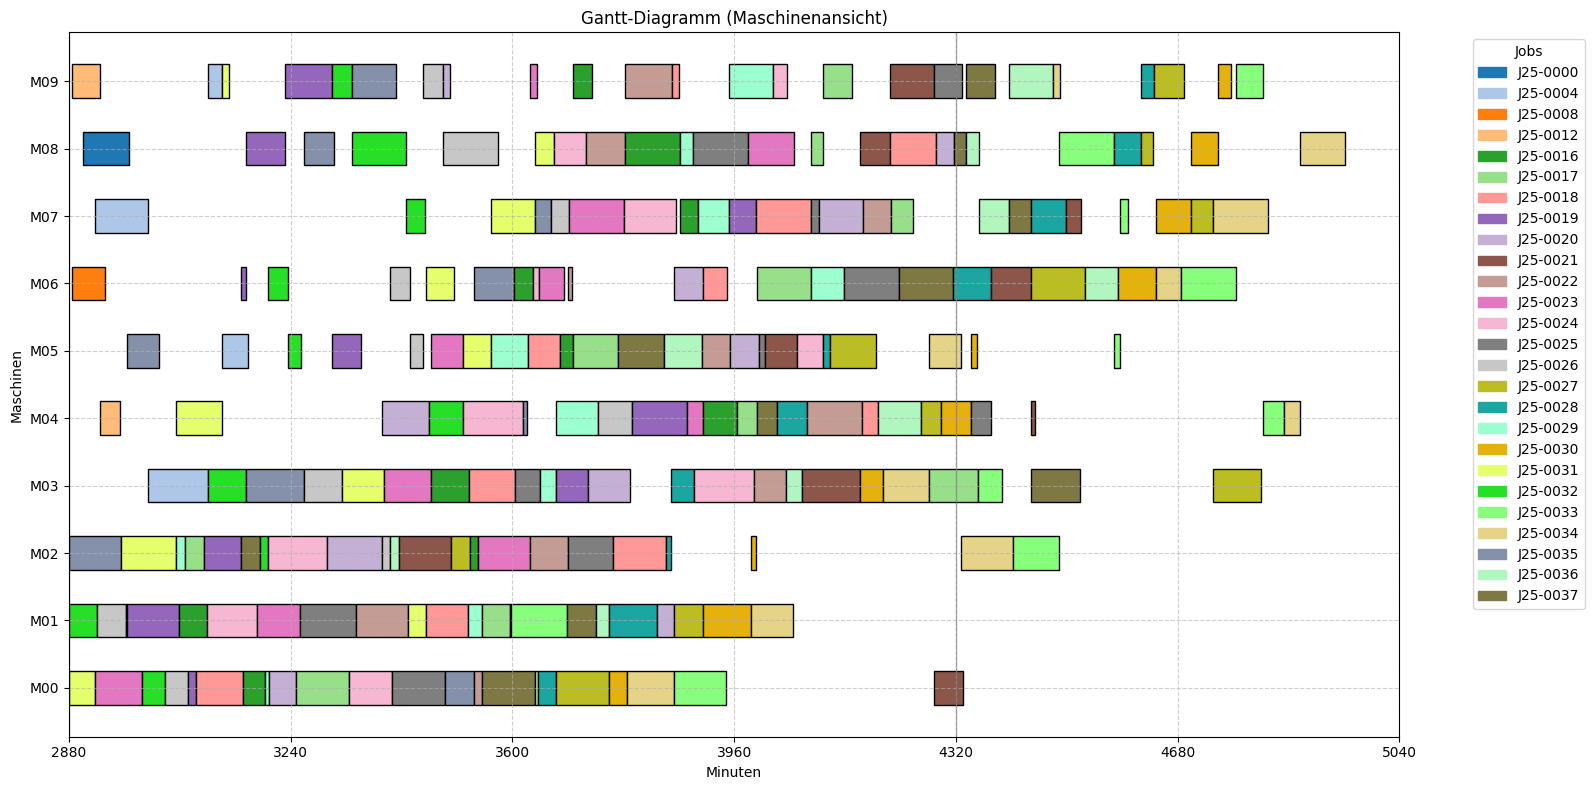

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [24]:
df_temp =  df_schedule_devpen

show.plot_gantt_machines(df_temp)
check.is_machine_conflict_free(df_temp)
check.is_operation_sequence_correct(df_temp)
check.is_job_timing_correct(df_temp)
check.is_start_correct(df_temp)

#### Check der Bedingungen des kombinierten Datensatzes aus den Simulationsdaten mit dem neuen Schedule

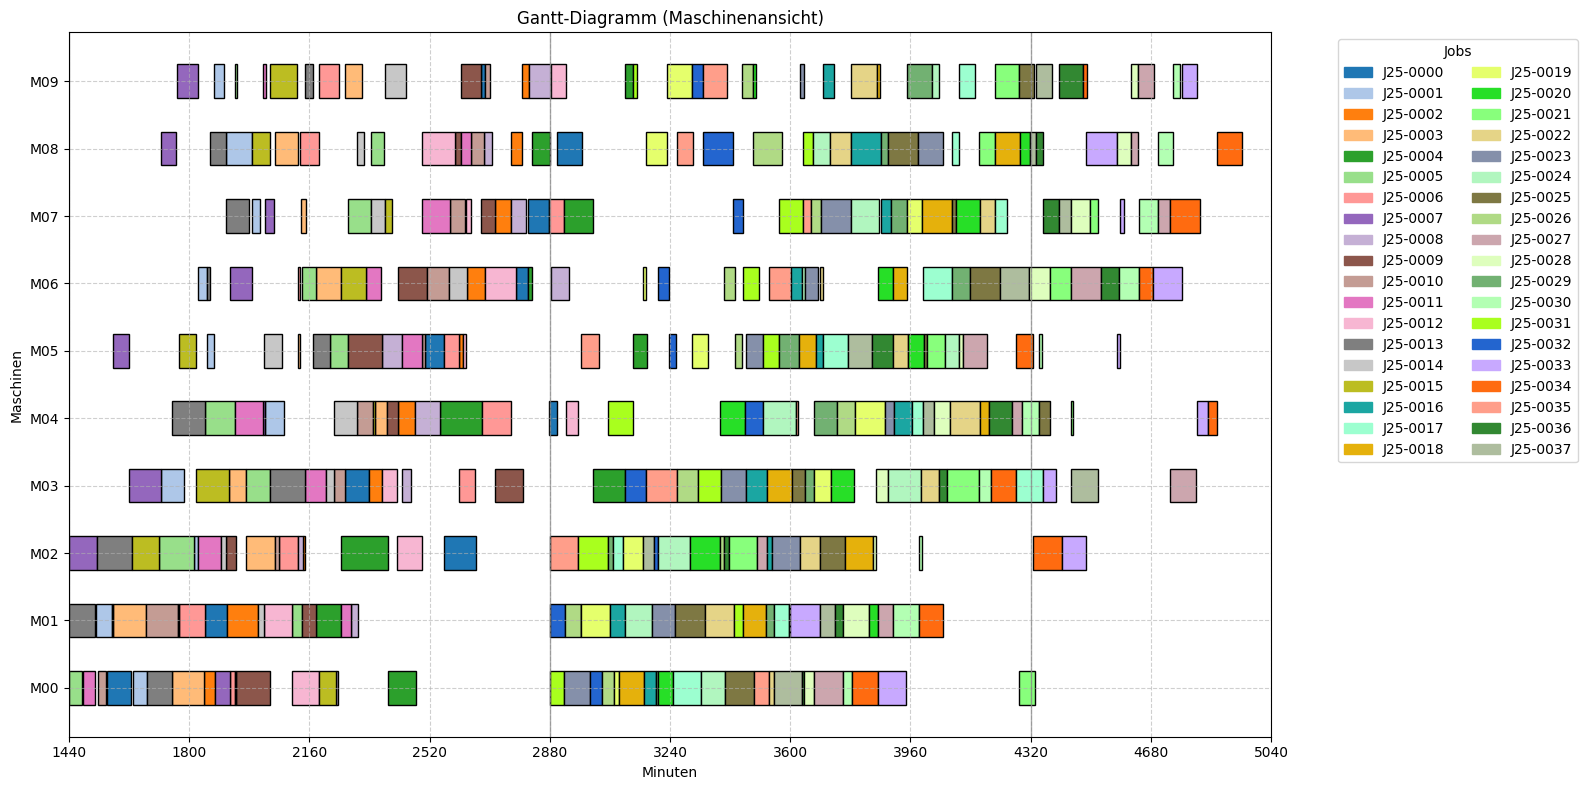

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [25]:
df_reschedule = df_schedule_devpen

columns = ["Job", "Operation", "Machine", "Arrival", "Start", "Processing Time", "End"]
df_combined = pd.concat([df_execution, df_active[columns], df_reschedule[columns]], ignore_index=True)
show.plot_gantt_machines(df_combined)
check.is_machine_conflict_free(df_combined)
check.is_operation_sequence_correct(df_combined)
check.is_job_timing_correct(df_combined)
check.is_start_correct(df_combined)


### Simulation

In [26]:
simulation.run(dframe_schedule_plan = df_schedule_devpen, start_time = day_start, end_time = day_end)

[Day 2 00:00:00] Job J25-0008, Operation 8 resumed with 5.00 min
[Day 2 00:00:00] Job J25-0004, Operation 5 resumed with 1.00 min
[Day 2 00:00:00] Job J25-0006, Operation 9 resumed with 43.00 min
[Day 2 00:00:00] Job J25-0000, Operation 8 resumed with 23.00 min
[Day 2 00:00:00] Job J25-0031 started on M00
[Day 2 00:00:00] Job J25-0032 started on M01
[Day 2 00:00:00] Job J25-0035 started on M02
[Day 2 00:01:00] Job J25-0004 finished on M08 (after 01 minute)
[Day 2 00:05:00] Job J25-0008 finished on M09 (after 05 minutes)
[Day 2 00:05:00] Job J25-0008 started on M06
[Day 2 00:05:00] Job J25-0012 started on M09
[Day 2 00:23:00] Job J25-0000 finished on M04 (after 23 minutes)
[Day 2 00:23:00] Job J25-0000 started on M08
[Day 2 00:34:00] Job J25-0032 finished on M01 (after 34 minutes)
[Day 2 00:43:00] Job J25-0006 finished on M07 (after 43 minutes)
[Day 2 00:43:00] Job J25-0031 finished on M00 (after 43 minutes)
[Day 2 00:43:00] Job J25-0004 started on M07
[Day 2 00:43:00] Job J25-0023 star

In [27]:
df_execution2 = simulation.get_finished_operations_df()
df_execution2

,Job,Operation,Machine,Arrival,Start,Processing Time,End,Routing_ID
0,J25-0000,8,M04,79,2879.0,24.0,2903.0,NaN
1,J25-0000,9,M08,79,2903.0,83.0,2986.0,8.0
2,J25-0004,5,M08,287,2826.0,55.0,2881.0,NaN
3,J25-0004,6,M07,287,2923.0,112.0,3035.0,3.0
4,J25-0004,7,M03,287,3035.0,149.0,3184.0,3.0
5,J25-0004,8,M09,287,3184.0,29.0,3213.0,3.0
...,...,...,...,...,...,...,...,...
173,J25-0036,4,M03,2734,4150.0,28.0,4178.0,4.0
174,J25-0037,0,M02,2801,3164.0,31.0,3195.0,7.0
175,J25-0037,1,M00,2801,3550.0,81.0,3631.0,7.0


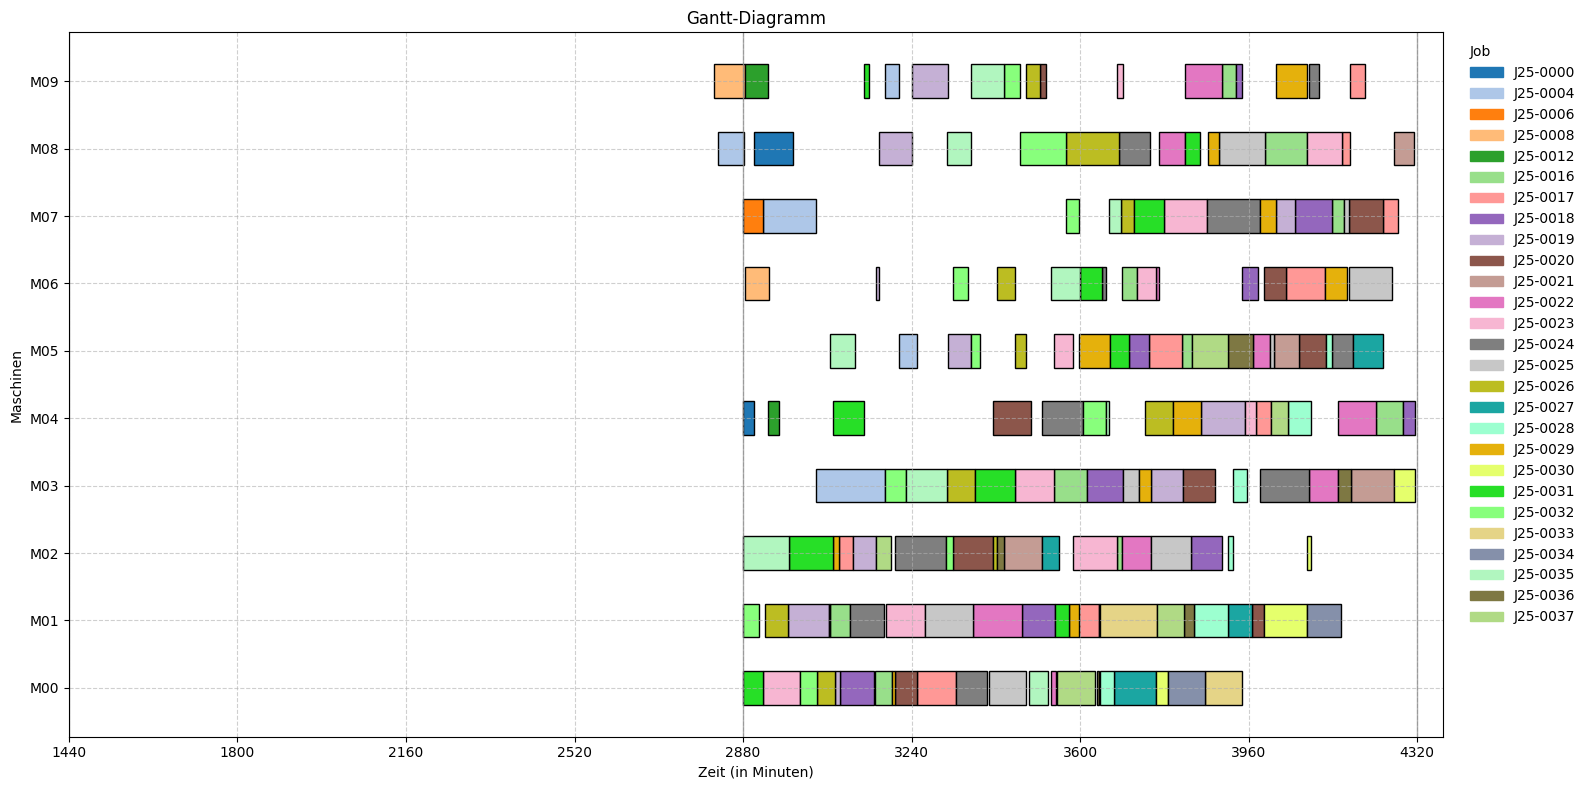

In [28]:
show.plot_gantt(df_execution2, perspective="Machine")

In [29]:
df_active2 = simulation.get_active_operations_df()
df_active2

,Job,Operation,Machine,Arrival,Start,Planned Duration,Processing Time,Expected End,End
0,J25-0020,9,M08,1935,4313.0,30,35.0,4343.0,4348.0
1,J25-0022,9,M07,2001,4278.0,45,45.0,4323.0,4323.0
2,J25-0025,8,M09,2126,4285.0,45,39.0,4330.0,4324.0
3,J25-0034,2,M03,2715,4315.0,76,85.0,4391.0,4400.0
4,J25-0036,5,M04,2734,4316.0,69,49.0,4385.0,4365.0
5,J25-0037,5,M06,2801,4266.0,88,86.0,4354.0,4352.0


In [30]:
df_not_started2 = simulation.get_not_started_operations_df(df_schedule)
df_not_started2

,Job,Routing_ID,Arrival,Ready Time,Deadline,Operation,Machine,Start,Processing Time,End
0,J25-0000,8,79,1440,3660,0,M00,1555,76,1631
1,J25-0000,8,79,1440,3660,1,M01,1825,69,1894
2,J25-0000,8,79,1440,3660,2,M03,2224,76,2300
3,J25-0000,8,79,1440,3660,3,M05,2417,51,2468
4,J25-0000,8,79,1440,3660,4,M02,2468,85,2553
5,J25-0000,8,79,1440,3660,5,M09,2553,11,2564
...,...,...,...,...,...,...,...,...,...,...
142,J25-0015,5,1436,1440,2981,4,M08,1988,48,2036
143,J25-0015,5,1436,1440,2981,5,M09,2036,72,2108
144,J25-0015,5,1436,1440,2981,6,M00,2170,47,2217


#### Check der Bedingungen des kombinierten Datensatzes aus den beiden Simulationsdaten

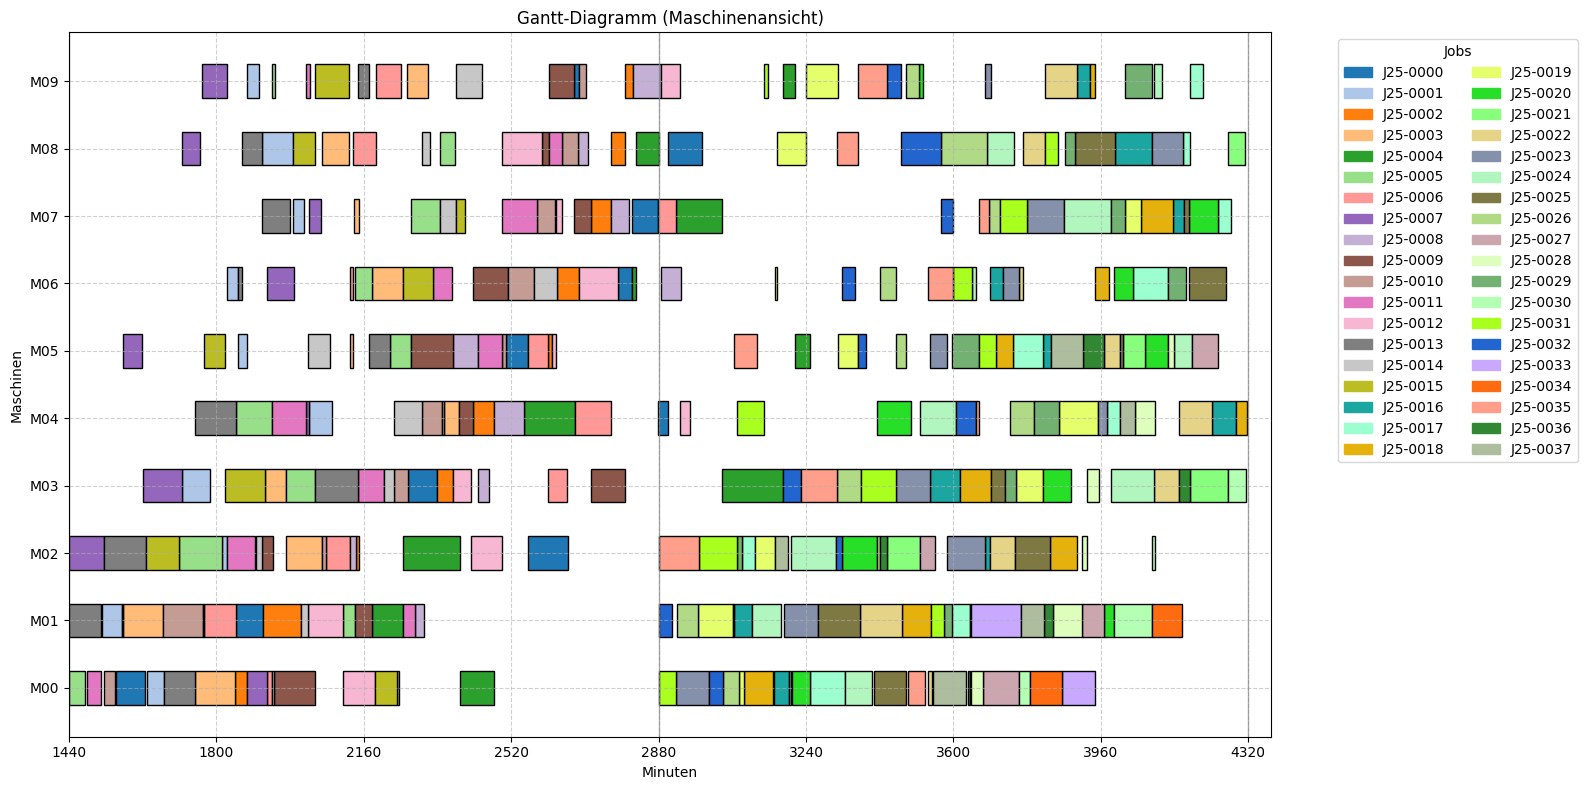

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [31]:
df_combined = pd.concat([df_execution, df_execution2], ignore_index=True)
show.plot_gantt_machines(df_combined)
check.is_machine_conflict_free(df_combined)
check.is_operation_sequence_correct(df_combined)
check.is_job_timing_correct(df_combined)
check.is_start_correct(df_combined)